In [57]:
RANDOM_SEED = 42

In [58]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import pickle
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score

In [59]:
BENIGN_LABEL = 0
ANOMALY_LABEL = 1

In [60]:
train_stage_1_3_OCSVM = pd.read_csv("data/train_stage_1_3_OCSVM.csv")

X_train = train_stage_1_3_OCSVM.drop(columns=["Label"])
y_train = np.ones(len(train_stage_1_3_OCSVM["Label"])) * BENIGN_LABEL

del train_stage_1_3_OCSVM

In [61]:
validation_stage_1_3 = pd.read_csv("data/validation_stage_1_3.csv")

X_val = validation_stage_1_3.drop(columns=["Label"])
y_val = np.where(validation_stage_1_3["Label"] == "BENIGN", BENIGN_LABEL, ANOMALY_LABEL)

del validation_stage_1_3

In [62]:
# Optimized pipelines
f = open("Repositório_Base/models/stage1_ocsvm.p","rb")
stage1 = pickle.load(f)
f.close()

stage1.fit(X_train)

c:\Users\henri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator QuantileTransformer from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\henri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator PCA from version 1.1.1 when using version 1.4.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\henri\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator One

[LibSVM]

Pipeline(steps=[('scaler',
                 QuantileTransformer(output_distribution='normal',
                                     subsample=100000)),
                ('pca', PCA(n_components=56, random_state=42)),
                ('ocsvm',
                 OneClassSVM(gamma=0.0632653906314333, nu=0.0002316646233151,
                             verbose=True))])

In [63]:
y_pred_train = stage1.predict(X_train) #marcando 1 como benigno
np.unique(y_pred_train, return_counts=True)

(array([-1,  1], dtype=int64), array([ 950, 9050], dtype=int64))

In [64]:
y_score_train = stage1.score_samples(X_train)
y_score_train.min(),y_score_train.max()

(0.004610011420169892, 0.008575120473614289)

In [9]:
validation_stage_1_3_OCSVM = pd.read_csv("data/validation_stage_1_3.csv")

X_val = validation_stage_1_3_OCSVM.drop(columns=["Label"])
y_val = validation_stage_1_3_OCSVM["Label"]

y_val = np.where(y_val == "BENIGN", 0,1) # marcando 1 como anomalia

del validation_stage_1_3_OCSVM

In [32]:
y_pred = stage1.predict(X_val)
y_score = stage1.score_samples(X_val)
print(y_pred[:10])
print(y_score[:10])


[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
[7.13895133e-10 1.31734901e-12 7.05274833e-05 4.90087932e-09
 1.38382037e-10 1.04314511e-10 1.38429914e-10 3.58145973e-10
 1.39964249e-10 2.47227542e-11]


In [21]:
np.unique(y_val, return_counts= True)

(array([0, 1]), array([129485,   6820], dtype=int64))

In [66]:
y_score = stage1.score_samples(X_val)

y_pred = stage1.predict(X_val)

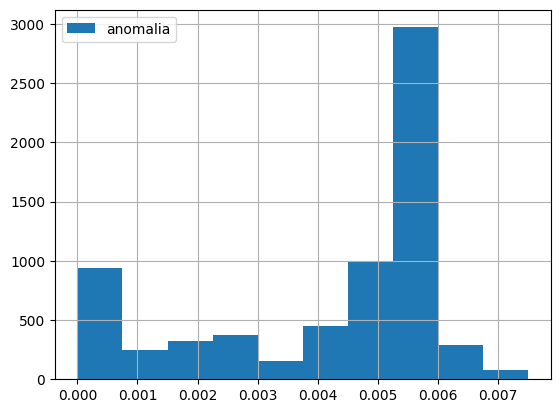

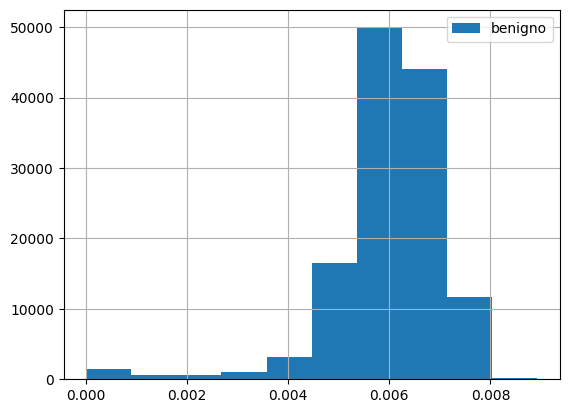

1.2963033424462367e-12 0.008922116447870726
2.1624520750440634e-11 0.007504173384560174


In [67]:
y_score_benigno  = pd.Series(y_score[y_val == BENIGN_LABEL])
y_score_anomalia = pd.Series(y_score[y_val == ANOMALY_LABEL])


y_score_anomalia.hist(label= "anomalia")
plt.legend()
plt.show()

y_score_benigno.hist(label= "benigno")
plt.legend()
plt.show()

print(y_score_benigno.min(),y_score_benigno.max())
print(y_score_anomalia.min(),y_score_anomalia.max())


In [36]:
y_pred_ = np.where(y_pred== 1, 0,1)
print(classification_report(y_val, y_pred_))
print(roc_auc_score(y_val, y_score))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00    129485
           1       0.05      1.00      0.10      6820

    accuracy                           0.05    136305
   macro avg       0.03      0.50      0.05    136305
weighted avg       0.00      0.05      0.00    136305

0.6962403603854974


d:\Disciplinas\intrusao\Projeto\Sistema_Hierarquico\Deteccao_de_Intrusao_Hierarquica_Multiestagio\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Disciplinas\intrusao\Projeto\Sistema_Hierarquico\Deteccao_de_Intrusao_Hierarquica_Multiestagio\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Disciplinas\intrusao\Projeto\Sistema_Hierarquico\Deteccao_de_Intrusao_Hierarquica_Multiestagio\env\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defi